In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score

In [3]:
def Preprocess(filepath):
    ext = filepath.split(".")

    if ext[1] == 'xlsx': 
        df = pd.read_excel(filepath, index_col=0)
        df['Date'] = pd.to_datetime(df['Date'])
    elif ext[1] == 'csv':
        df = pd.read_csv(filepath, index_col=0)
        df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")

    try:
        df["Hour"] = pd.to_datetime(df["Start Time"] , format="%H:%M:%S").dt.hour
    except:
        df["Hour"] = pd.to_datetime(df["Start Time"] , format="%H:%M").dt.hour
    
    df["Session Duration (mins)"] = (df["Total Focus Duration (mins)"] + df["Distraction Duration (mins)"])
    df['Session Length'] = df["Session Duration (mins)"].apply(lambda x:min(90 , 15 * round(x/15)))
    df["Task Type"] = df["Task Type"].apply(lambda x: x.lower())
    df["Day"] = df["Day"].apply(lambda x: x.lower())
    df.drop(df[df["Session Length"] == 0].index , inplace =True)
    df.drop(columns=["Start Time" , "End Time"],inplace=True)
    df = df.dropna().reset_index(drop=True)

    return df

In [4]:
df1 = Preprocess("dataset/student1.csv")
df2 = Preprocess("dataset/student2.csv")
df3 = Preprocess("dataset/student3.csv")
df4 = Preprocess("dataset/student4.csv")
df5 = Preprocess("dataset/student5.csv")
df6 = Preprocess("dataset/student6.csv")
df7 = Preprocess("dataset/student7.csv")
df8 = Preprocess("dataset/student8.csv")
df9 = Preprocess("dataset/student9.csv")
df10 = Preprocess("dataset/focus.xlsx")
df11 = Preprocess("dataset/focus_data.csv")

NameError: name 'pd' is not defined

In [341]:
dfs = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11]
combined_df = pd.concat(dfs).reset_index(drop=True)

In [342]:
combined_df = combined_df.fillna(0)

In [343]:
tt_encode = LabelEncoder()
d_encode = LabelEncoder()
combined_df["Task Type"] = tt_encode.fit_transform(combined_df["Task Type"])
combined_df["Day"] = d_encode.fit_transform(combined_df["Day"])

In [344]:
combined_df.head()

,Date,Day,Task Type,App Switch Count,Distraction Duration (mins),Total Focus Duration (mins),Focus Score (0-10),Productivity %,Hour,Session Duration (mins),Session Length
0,2025-02-01,2,3,3,11.0,27.0,7,71.05,9,38.0,45
1,2025-02-01,2,4,1,8.0,26.0,3,76.47,12,34.0,30
2,2025-02-02,3,0,1,9.0,19.0,7,67.86,16,28.0,30
3,2025-02-02,3,2,0,36.0,40.0,1,52.63,15,76.0,75
4,2025-02-02,3,1,1,24.0,11.0,4,31.43,12,35.0,30


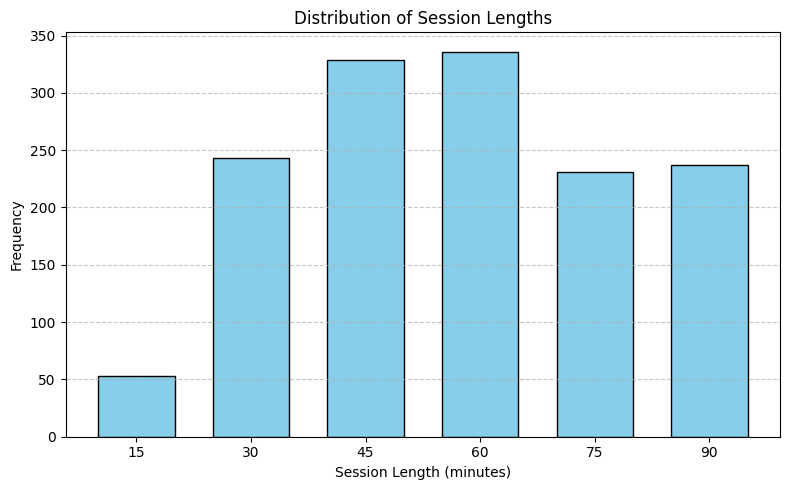

In [345]:
session_counts = pd.Series(b).value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(session_counts.index, session_counts.values, width=10, color='skyblue', edgecolor='black')
plt.xlabel("Session Length (minutes)")
plt.ylabel("Frequency")
plt.title("Distribution of Session Lengths")
plt.xticks(session_counts.index)  # Ensure all x labels are shown
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [346]:
m = combined_df["Focus Score (0-10)"][20:30].idxmax()
combined_df["Session Length"][m]

np.int64(90)

In [347]:
X = combined_df[['App Switch Count','Distraction Duration (mins)','Focus Score (0-10)','Productivity %','Hour','Task Type','Day']]
y = combined_df["Session Length"]

In [348]:
model = DecisionTreeClassifier(random_state=1,class_weight='balanced')

In [349]:
model.fit(X,y)

DecisionTreeClassifier(class_weight='balanced', random_state=1)

In [350]:
with open("Best_Length.pkl", "wb") as f:
    pickle.dump({"model" :model,
                 "tt_en" : tt_encode,
                 "d_en" : d_encode}, f)

In [351]:
def Pomodro_df(app_switch ,task, dist,focus_score,productivity,hour,day):
    df = {'App Switch Count': app_switch, 'Task Type': task.lower(),'Distraction Duration (mins)': dist,
        'Focus Score (0-10)': focus_score, 'Productivity %': productivity, "Hour" : hour ,"Day": day}
    df = pd.DataFrame(df, index=[0])

    df["Task Type"] = tt_encode.transform(df["Task Type"])
    df["Day"] = d_encode.transform(df["Day"])

    df = df.dropna().reset_index(drop=True)

    return df[['App Switch Count','Distraction Duration (mins)','Focus Score (0-10)','Productivity %','Hour','Task Type','Day']]
    


In [384]:
find = Pomodro_df(app_switch = 4,
                  task="coding",
                 dist=0,
                 focus_score=10,
                 productivity=100,
                 hour=18,
                 day="monday")

In [385]:
model.predict(find)

array([30])

In [386]:
with open("Best_Length.pkl", "rb") as file:
    al = pickle.load(file)
    model1 = al["model"]
    tt_enc = al["tt_en"]
    d_enc = al["d_en"]
    

In [387]:
model1.predict(find)

array([30])

In [388]:
combined_df[combined_df["Session Length"] == 15]

,Date,Day,Task Type,App Switch Count,Distraction Duration (mins),Total Focus Duration (mins),Focus Score (0-10),Productivity %,Hour,Session Duration (mins),Session Length
8,2025-02-05,6,3,1,1.000,15.000,2,93.750,9,16.000,15
30,2025-02-14,0,1,3,2.000,10.000,5,83.330,11,12.000,15
45,2025-02-22,2,1,3,1.000,20.000,4,95.240,14,21.000,15
63,2025-03-04,5,0,2,3.000,12.000,1,80.000,13,15.000,15
75,2025-03-11,5,3,3,1.000,17.000,5,94.440,18,18.000,15
...,...,...,...,...,...,...,...,...,...,...,...
1409,2025-03-24,1,3,11,1.693,15.000,2,89.853,11,16.693,15
1414,2025-03-25,5,2,28,8.885,1.115,1,11.149,8,10.000,15
1415,2025-03-26,6,3,29,8.176,11.824,1,59.117,18,20.000,15
1416,2025-03-26,6,3,16,8.673,1.327,1,13.269,15,10.000,15
